```python   
Project Aeacus
Created by Gil on 9/24/2025
Updated by Gil on 10/07/2025
```

# Bond2Vec: A Multi-Task Learning Framework for Municipal Bond Embeddings

## Overview

Bond2Vec learns municipal bond embeddings from **market behavior** rather than static attributes. Using a **Siamese neural network**, bonds are mapped into a low-dimensional space where proximity reflects **how they trade together**.

This framework:

* Builds **positive/negative training pairs** by computing short trade histories dot product, TODO: try longer trade history matrix
* Uses a **shared neural encoder** to embed each bond’s reference features.
* Trains embeddings so that bonds with similar behavior are close in space.
* Allows downstream tasks like arbitrage discovery, portfolio clustering, and cold-start pricing.



## Core Concepts

### 1. Pair Creation via Trade Histories

* Each bond has a **5×6 trade-history matrix** encoding its last 5 trades:

| Feature            | Description                 | Example   |
| ------------------ | --------------------------- | --------- |
| Yield Spread       | Bond yield – FICC curve     | 101.4 bps |
| Treasury Spread    | Bond yield – Treasury yield | 19.0 bps  |
| log₁₀(Par)         | Normalized trade size       | 4.7       |
| Trade Type 1/2     | Encoded trade directions    | 0, 1      |
| log₁₀(Seconds Ago) | Time since trade            | 2.18      |

* We flatten each matrix into a vector `h(x)`.
* Compute **cosine similarity** between two bonds’ histories:

$$
s(x, x') = \frac{h(x) \cdot h(x')}{\|h(x)\|\|h(x')\|}
$$

* If `s > 0.5`: positive pair (similar behavior).
* If `s < 0.2`: negative pair.

> This step produces **labels** for training. At inference, only ref features (coupon, rating, state, etc.) and sythetic trades features are needed.



### 2. Embedding Framework

We formalize prediction tasks as:

* **Unary tasks** (e.g. “Will this bond trade tomorrow?”)
  $\mathcal{Z}_t = \mathcal{X}$, $\mathcal{Y}_t \in \mathbb{R} \text{ or } \{-1,+1\}$
* **Binary tasks** (e.g. “Will bonds co-trade?”)
  $\mathcal{Z}_t = \mathcal{X} \times \mathcal{X}$

We embed each bond into a $k$-dimensional space:

$$
g : \mathcal{X} \to \mathbb{R}^k, \quad k < d
$$

and define a task-specific predictor:

$$
f_t(x, x') = g(x)^\top M_t g(x') + b_t
$$

* $g(x)$: embedding of bond $x$
* $M_t$: learned matrix (not forced symmetric → allows directionality)
* $b_t$: bias

Interpretation: $f_t(x, x')$ is high when embeddings are behaviorally similar.



### 3. Siamese Neural Network

The encoder $g(x)$ is implemented as a **Siamese network**: two identical subnetworks with shared weights.

**Architecture**:

* Input: ~301 engineered features per bond
* Hidden layers: 512 → 256 → 256 (ReLU + BatchNorm + Dropout)
* Output: 128-dim embedding, L2-normalized

**Diagram (conceptual)**:

```
CUSIP A features ─▶ Base Network ─▶ Embedding A ─┐
                                                 ├─▶ Dot Product → Similarity Score
CUSIP B features ─▶ Base Network ─▶ Embedding B ─┘
```

Training uses **contrastive loss**:

$$
\ell(y,\hat{y}) = y(1-\hat{y})^2 + (1-y)\max(0,\hat{y}-m)^2
$$

* $y = 1$ for similar, $0$ otherwise
* $\hat{y}$: predicted similarity
* $m$: margin to separate negatives

Errors backpropagate into the encoder, shaping the embedding space.



## More information: 

* **Linear algebra primer**:

  * Dot product = similarity measure.
  * Cosine similarity = dot product of normalized vectors.
* **Pair creation**: Dot products on short trade histories → labels.
* **Siamese network**: Learns embeddings from reference data.
* **Embeddings**: At inference, you only need static bond features; the network places bonds into a latent behavioral space.



## Propsoed Production Use Cases

* **Which CUSIPs to sell**: flag CUSIPs that should be sold / will be sold
* **Arbitrage scanner**: flag pairs with high similarity but yield gaps.
* **Easy new issue pricing**
* **Liquidity Score**
* **Price illiquids**
* **Improve accuracy of current models**: use better sims
* **Portfolio analysis**: measure concentration in “behavioral clusters.”
* **pricing**: estimate fair value for illiquid bonds.
* **Anomaly detection**: spot bonds diverging from their peers.


```

Trade History Array Structure - ToDo: use longer trade histories

[yield_spread, treasury_spread, log_par_traded, trade_type_1, trade_type_2, log_seconds_ago]
```

| Index | Feature | Description | Example Value |
|-------|---------|-------------|---------------|
| 0 | **Yield Spread** | Bond yield × 100 - FICC yield curve level (basis points) | 101.42 |
| 1 | **Treasury Spread** | (Bond yield - Treasury rate) × 100 (basis points, rounded to 3 decimals) | 19.0 |
| 2 | **Log Par Traded** | log₁₀(trade size) - normalizes trade sizes | 4.70 |
| 3 | **Trade Type 1** | First component of trade type encoding | 0.0 |
| 4 | **Trade Type 2** | Second component of trade type encoding | 0.0 |
| 5 | **Log Seconds Ago** | log₁₀(1 + seconds since trade) - normalizes time decay | 2.18 |


## What behavioral embeddings capture:

- **Liquidity co-movement**: Bonds that trade together
- **Market microstructure**: Which bonds move as a bloc during market events
- **Substitutability**: What investors actually consider as alternatives
- **Portfolio construction**: Natural diversification boundaries

## Where this matters:

- **Tax-loss harvesting**: Find bonds with similar trading behavior but different tax lots
- **Liquidity management**: Identify which bonds can actually be sold quickly
- **Portfolio rebalancing**: Understand which bonds are redundant vs. diversifying
- **"What should I sell?"**: Find liquid substitutes within a portfolio

In [35]:
# Fetch Recent Trades with Reference Data
# Goal: Get recent trades from MSRB + reference data from Redis
# Creates a complete DataFrame ready for feature engineering and embedding
# ONE ROW PER CUSIP using most recent trade

import pandas as pd
import numpy as np
from google.cloud import bigquery
import redis
import pickle
from datetime import datetime, timedelta
import os

# CONFIGURATION

LOOKBACK_HOURS = 8  # How far back to fetch trades (24 hours = 1 day, 0.5 = 30 min)
REDIS_HOST = 'localhost' 
REDIS_PORT = 6379
REDIS_DB = 0

# Set up credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/gil/git/ficc/creds.json"

print(f"Fetching trades ...")

# STEP 1: FETCH RECENT TRADES FROM MSRB

client = bigquery.Client()

# Query for recent trades - only get fields we need from MSRB
query = f"""
SELECT 
    rtrs_control_number,
    cusip,
    trade_type,
    transaction_type,
    par_traded,
    dollar_price,
    yield,
    trade_date,
    time_of_trade,
    DATETIME(TIMESTAMP(CONCAT(CAST(trade_date AS STRING), ' ', CAST(time_of_trade AS STRING)))) as trade_datetime,
    settlement_date,
    when_issued,
    is_non_transaction_based_compensation
FROM `eng-reactor-287421.MSRB.msrb_trade_messages`
WHERE trade_date >= "2025-10-09"
ORDER BY trade_datetime DESC
"""

print("\nQuerying MSRB for recent trades...")
trades_df = client.query(query).to_dataframe()

print(f" Fetched {len(trades_df):,} trades")
print(f"  Date range: {trades_df['trade_datetime'].min()} to {trades_df['trade_datetime'].max()}")
print(f"  Unique CUSIPs: {trades_df['cusip'].nunique():,}")

# STEP 1.5: DEDUPLICATE TO ONE ROW PER CUSIP (MOST RECENT TRADE)
print("\nDeduplicating to one row per CUSIP...")
trades_df_deduped = (
    trades_df
    .sort_values(['cusip', 'trade_datetime', 'par_traded', 'rtrs_control_number'], 
                 ascending=[True, False, False, False])  # Sort by time DESC to get latest first
    .drop_duplicates(subset=['cusip'], keep='first')  # Keep first = most recent
    .reset_index(drop=True)
)

print(f"✓ Reduced from {len(trades_df):,} trades to {len(trades_df_deduped):,} CUSIPs")
print(f"  Each CUSIP now has exactly 1 row with its most recent trade data")

# STEP 2: BATCH FETCH REFERENCE DATA FROM REDIS

# Connect to Redis
redis_client = redis.Redis(host=REDIS_HOST, port=REDIS_PORT, db=REDIS_DB)

# Get unique CUSIPs (should already be unique after dedup, but just to be safe)
unique_cusips = trades_df_deduped['cusip'].unique()
print(f"\nFetching reference data for {len(unique_cusips):,} unique CUSIPs from Redis...")

# Reference data feature list (must match Redis storage order)
REFERENCE_DATA_FEATURES = [
    'coupon', 'cusip', 'ref_valid_from_date', 'ref_valid_to_date',
    'incorporated_state_code', 'organization_primary_name', 'instrument_primary_name',
    'issue_key', 'issue_text', 'conduit_obligor_name', 'is_called', 'is_callable',
    'is_escrowed_or_pre_refunded', 'first_call_date', 'call_date_notice',
    'callable_at_cav', 'par_price', 'call_defeased', 'call_timing',
    'call_timing_in_part', 'extraordinary_make_whole_call', 'extraordinary_redemption',
    'make_whole_call', 'next_call_date', 'next_call_price', 'call_redemption_id',
    'first_optional_redemption_code', 'second_optional_redemption_code',
    'third_optional_redemption_code', 'first_mandatory_redemption_code',
    'second_mandatory_redemption_code', 'third_mandatory_redemption_code',
    'par_call_date', 'par_call_price', 'maximum_call_notice_period',
    'call_frequency', 'called_redemption_type', 'muni_issue_type', 'refund_date', 'refund_price',
    'redemption_cav_flag', 'max_notification_days', 'min_notification_days',
    'next_put_date', 'put_end_date', 'put_feature_price', 'put_frequency',
    'put_start_date', 'put_type', 'maturity_date', 'sp_long', 'sp_stand_alone',
    'sp_icr_school', 'sp_prelim_long', 'sp_outlook_long', 'sp_watch_long',
    'sp_Short_Rating', 'sp_Credit_Watch_Short_Rating', 'sp_Recovery_Long_Rating',
    'moodys_long', 'moodys_short', 'moodys_Issue_Long_Rating',
    'moodys_Issue_Short_Rating', 'moodys_Credit_Watch_Long_Rating',
    'moodys_Credit_Watch_Short_Rating', 'moodys_Enhanced_Long_Rating',
    'moodys_Enhanced_Short_Rating', 'moodys_Credit_Watch_Long_Outlook_Rating',
    'has_sink_schedule', 'next_sink_date', 'sink_indicator', 'sink_amount_type_text',
    'sink_amount_type_type', 'sink_frequency', 'sink_defeased',
    'additional_next_sink_date', 'sink_amount_type', 'additional_sink_frequency',
    'min_amount_outstanding', 'max_amount_outstanding', 'default_exists',
    'has_unexpired_lines_of_credit', 'years_to_loc_expiration', 'escrow_exists',
    'escrow_obligation_percent', 'escrow_obligation_agent', 'escrow_obligation_type',
    'child_linkage_exists', 'put_exists', 'floating_rate_exists',
    'bond_insurance_exists', 'is_general_obligation', 'has_zero_coupons',
    'delivery_date', 'issue_price', 'primary_market_settlement_date', 'issue_date',
    'outstanding_indicator', 'federal_tax_status', 'maturity_amount',
    'available_denom', 'denom_increment_amount', 'min_denom_amount', 'accrual_date',
    'bond_insurance', 'coupon_type', 'current_coupon_rate', 'daycount_basis_type',
    'debt_type', 'default_indicator', 'first_coupon_date',
    'interest_payment_frequency', 'issue_amount', 'last_period_accrues_from_date',
    'next_coupon_payment_date', 'odd_first_coupon_date', 'orig_principal_amount',
    'original_yield', 'outstanding_amount', 'previous_coupon_payment_date',
    'sale_type', 'settlement_type', 'additional_project_txt', 'asset_claim_code',
    'additional_state_code', 'backed_underlying_security_id', 'bank_qualified',
    'capital_type', 'conditional_call_date', 'conditional_call_price',
    'designated_termination_date', 'DTCC_status', 'first_execution_date',
    'formal_award_date', 'maturity_description_code', 'muni_security_type',
    'mtg_insurance', 'orig_cusip_status', 'orig_instrument_enhancement_type',
    'other_enhancement_type', 'other_enhancement_company', 'pac_bond_indicator',
    'project_name', 'purpose_class', 'purpose_sub_class', 'refunding_issue_key',
    'refunding_dated_date', 'sale_date', 'sec_regulation', 'secured', 'series_name',
    'sink_fund_redemption_method', 'state_tax_status', 'tax_credit_frequency',
    'tax_credit_percent', 'use_of_proceeds', 'use_of_proceeds_supplementary',
    'series_id', 'security_description'
]

# Batch fetch from Redis using mget for efficiency
ref_data_list = []
missing_cusips = []

# Process in batches to avoid memory issues
BATCH_SIZE = 1000
for i in range(0, len(unique_cusips), BATCH_SIZE):
    batch_cusips = unique_cusips[i:i+BATCH_SIZE].tolist()
    
    # Use mget for batch fetching - faster than pipeline for pure reads
    results = redis_client.mget(batch_cusips)
    
    # Process results
    for cusip, result in zip(batch_cusips, results):
        if result is not None:
            # Deserialize the deque
            reference_data_deque = pickle.loads(result)
            # Get most recent snapshot (first item in deque)
            reference_data = reference_data_deque[0]
            
            # Create dict with cusip as key
            ref_dict = {'cusip': cusip}
            for idx, feature in enumerate(REFERENCE_DATA_FEATURES):
                if idx < len(reference_data):
                    ref_dict[feature] = reference_data[idx]
            ref_data_list.append(ref_dict)
        else:
            missing_cusips.append(cusip)
    
    if (i + BATCH_SIZE) % 5000 == 0:
        print(f"  Processed {min(i + BATCH_SIZE, len(unique_cusips)):,}/{len(unique_cusips):,} CUSIPs...")

# Create reference data DataFrame
ref_df = pd.DataFrame(ref_data_list)

print(f" Fetched reference data for {len(ref_df):,} CUSIPs")
if missing_cusips:
    print(f"  ⚠ Warning: {len(missing_cusips)} CUSIPs not found in Redis")
    print(f"    Examples: {missing_cusips[:5]}")

# STEP 3: JOIN TRADES WITH REFERENCE DATA

print("\nJoining trades with reference data...")

# Merge on CUSIP - now it's 1:1 join since both are deduplicated
final_df = trades_df_deduped.merge(ref_df, on='cusip', how='left')

# Verify we still have 1 row per CUSIP
assert len(final_df) == len(final_df['cusip'].unique()), "ERROR: Duplicate CUSIPs found after merge!"
print(f"✓ Verified: {len(final_df):,} CUSIPs, each with exactly 1 row")

# Convert date columns to datetime
date_columns = [
    'trade_date', 'trade_datetime', 'settlement_date', 
    'maturity_date', 'next_call_date', 'refund_date', 'par_call_date',
    'delivery_date', 'accrual_date', 'previous_coupon_payment_date',
    'next_coupon_payment_date', 'first_coupon_date', 'last_period_accrues_from_date',
    'next_sink_date', 'ref_valid_from_date', 'ref_valid_to_date'
]

for col in date_columns:
    if col in final_df.columns:
        final_df[col] = pd.to_datetime(final_df[col], errors='coerce')

# Add rating column (map sp_long to rating for feature engineering)
if 'sp_long' in final_df.columns:
    final_df['rating'] = final_df['sp_long'].fillna('NR')
else:
    final_df['rating'] = 'NR'

# Add dated_date as alias for accrual_date (required by feature engineering)
if 'accrual_date' in final_df.columns:
    final_df['dated_date'] = final_df['accrual_date']

# Clean data: remove trades settling >= 30 days from trade date (likely errors)
final_df['days_to_settle'] = (pd.to_datetime(final_df['settlement_date']) - pd.to_datetime(final_df['trade_date'])).dt.days
before_filter = len(final_df)
final_df = final_df[final_df['days_to_settle'] < 30].reset_index(drop=True)
after_filter = len(final_df)

if before_filter > after_filter:
    print(f"  Filtered out {before_filter - after_filter} trades with settlement >= 30 days")

# SUMMARY

print(f"\n{'='*60}")
print(f"FINAL DATASET SUMMARY")
print(f"{'='*60}")
print(f"Total CUSIPs: {len(final_df):,}")
print(f"Unique CUSIPs: {final_df['cusip'].nunique():,} (should match total)")
print(f"Date range: {final_df['trade_datetime'].min()} to {final_df['trade_datetime'].max()}")
print(f"CUSIPs with reference data: {final_df['coupon'].notna().sum():,}")
print(f"Average trades per CUSIP: {len(trades_df) / len(final_df):.1f} (original) → 1.0 (deduplicated)")
print(f"{'='*60}\n")

final_df.head()

Fetching trades ...

Querying MSRB for recent trades...
 Fetched 126,688 trades
  Date range: 2025-10-09 02:05:00 to 2025-10-10 16:52:58
  Unique CUSIPs: 43,888

Deduplicating to one row per CUSIP...
✓ Reduced from 126,688 trades to 43,888 CUSIPs
  Each CUSIP now has exactly 1 row with its most recent trade data

Fetching reference data for 43,888 unique CUSIPs from Redis...
  Processed 5,000/43,888 CUSIPs...
  Processed 10,000/43,888 CUSIPs...
  Processed 15,000/43,888 CUSIPs...
  Processed 20,000/43,888 CUSIPs...
  Processed 25,000/43,888 CUSIPs...
  Processed 30,000/43,888 CUSIPs...
  Processed 35,000/43,888 CUSIPs...
  Processed 40,000/43,888 CUSIPs...
 Fetched reference data for 43,626 CUSIPs
  ⚠ Warning: 262 CUSIPs not found in Redis
    Examples: ['012432EC0', '012432ED8', '012432EE6', '012432EF3', '012432EG1']

Joining trades with reference data...
✓ Verified: 43,888 CUSIPs, each with exactly 1 row
  Filtered out 314 trades with settlement >= 30 days

FINAL DATASET SUMMARY
Tota

/var/folders/6s/gj2fjqpx7kd1zydwmjp477dw0000gn/T/ipykernel_49493/2072900299.py:195: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df[col] = pd.to_datetime(final_df[col], errors='coerce')


,rtrs_control_number,cusip,trade_type,transaction_type,par_traded,dollar_price,yield,trade_date,time_of_trade,trade_datetime,...,sink_fund_redemption_method,state_tax_status,tax_credit_frequency,tax_credit_percent,use_of_proceeds,use_of_proceeds_supplementary,series_id,rating,dated_date,days_to_settle
0,2025101007638800,00037CWU0,S,I,300000.000000000,104.794,2.380,2025-10-10,13:02:10,2025-10-10 13:02:10,...,1.0,<NA>,<NA>,20.0,<NA>,ABAG FIN AUTH FOR NONPROFIT CORPS CALIF REVRef...,ABAG FIN AUTH FOR NONPROFIT CORPS CALIF REV Re...,NR,NaT,4
1,2025101010940200,00037CWV8,S,I,15000.000000000,104.254,2.667,2025-10-10,15:03:12,2025-10-10 15:03:12,...,1.0,<NA>,<NA>,20.0,<NA>,ABAG FIN AUTH FOR NONPROFIT CORPS CALIF REVRef...,ABAG FIN AUTH FOR NONPROFIT CORPS CALIF REV Re...,NR,NaT,4
2,2025100908001500,0004162Q9,D,I,5000.000000000,98.381,4.120,2025-10-09,12:54:40,2025-10-09 12:54:40,...,1.0,<NA>,<NA>,9.0,<NA>,A B C CALIF UNI SCH DISTGeneral Obligation Bon...,A B C CALIF UNI SCH DIST General Obligation Bo...,NR,NaT,1
3,2025100912522500,000416V38,D,I,20000.000000000,93.517,3.734,2025-10-09,14:55:05,2025-10-09 14:55:05,...,1.0,<NA>,<NA>,9.0,<NA>,A B C CALIF UNI SCH DISTGeneral Obligation Bon...,A B C CALIF UNI SCH DIST General Obligation Bo...,NR,NaT,1
4,2025100909300100,000416X51,P,I,15000.000000000,117.166,2.265,2025-10-09,13:32:17,2025-10-09 13:32:17,...,1.0,<NA>,<NA>,9.0,<NA>,A B C CALIF UNI SCH DISTElection of 2018 Gener...,A B C CALIF UNI SCH DIST Election of 2018 Gene...,NR,NaT,1


In [36]:
final_df = final_df[final_df.trade_date <= "2025-10-09"]
len(final_df)

20369

In [37]:
# Feature Engineering and Generate Embeddings Space: 

import sys
import os
import pickle
from tensorflow import keras

# Add modules directory to Python path
modules_path = '/Users/gil/git/ficc/notebooks/gil_modeling/embeddings/modules'
if modules_path not in sys.path:
    sys.path.insert(0, modules_path)

# Now import (without 'modules.' prefix since modules dir is in path)
from modules.feature_engineering import engineer_features_complete
from modules.siamese_network import get_embeddings

# Config
MODEL_PATH = '/Users/gil/git/ficc/notebooks/gil_modeling/embeddings/cusip_embedding_model_temporal.keras'
ARTIFACTS_PATH = '/Users/gil/git/ficc/notebooks/gil_modeling/embeddings/feature_artifacts_temporal.pkl'

print("Loading trained model and artifacts...")

base_network = keras.models.load_model(MODEL_PATH, compile=False)

with open(ARTIFACTS_PATH, 'rb') as f:
    artifacts = pickle.load(f)

print(f"Model loaded: {base_network.output_shape[1]}-dimensional embeddings")

# Generate embeddings
print(f"\nGenerating embeddings for {len(final_df):,} CUSIPs...")

embeddings_df = get_embeddings(
    cusip_features_df=final_df,
    base_network=base_network,
    artifacts=artifacts
)

print(f"embeddings_df{embeddings_df}")

# **ADD THIS: Merge yield data back into embeddings_df**
embeddings_df = embeddings_df.merge(
    final_df[['cusip', 'trade_datetime', 'yield']],
    on=['cusip', 'trade_datetime'],
    how='left'
)

print(f"Generated {len(embeddings_df):,} embeddings")
print(f"Embedding dimension: {base_network.output_shape[1]}")
embeddings_df.head()

Loading trained model and artifacts...
Model loaded: 128-dimensional embeddings

Generating embeddings for 20,369 CUSIPs...
Engineered 301 features from 20369 trades
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
embeddings_df           cusip      trade_datetime     emb_0     emb_1     emb_2     emb_3  \
0      0004162Q9 2025-10-09 12:54:40 -0.102400  0.160914 -0.052683 -0.009340   
1      000416V38 2025-10-09 14:55:05 -0.101371  0.165879 -0.045579 -0.009796   
2      000416X51 2025-10-09 13:32:17 -0.099271  0.172619 -0.035553 -0.012877   
3      00281PCT9 2025-10-09 15:05:46 -0.099302  0.172455 -0.035684 -0.012705   
4      003269EA1 2025-10-09 13:16:13 -0.098879  0.175041 -0.033884 -0.015028   
...          ...                 ...       ...       ...       ...       ...   
20364  989258QQ4 2025-10-09 10:48:02 -0.099606  0.170892 -0.037131 -0.010800   
20365  989258QY7 2025-10-09 12:11:58 -0.102277  0.161704 -0.051637 -0.009411   
20366  989654GP7 2025-10-09 10:20:29 -0.100245  0.169188 -0.03

,cusip,trade_datetime,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,yield
0,0004162Q9,2025-10-09 12:54:40,-0.102400,0.160914,-0.052683,-0.009340,-0.095287,0.095708,-0.042271,0.057964,...,-0.013473,-0.113999,0.000877,0.056320,-0.039960,-0.112871,0.016128,0.178752,0.107190,4.120
1,000416V38,2025-10-09 14:55:05,-0.101371,0.165879,-0.045579,-0.009796,-0.095376,0.096638,-0.045106,0.066473,...,-0.021004,-0.120507,0.001712,0.048193,-0.036879,-0.116124,0.017127,0.178900,0.101293,3.734
2,000416X51,2025-10-09 13:32:17,-0.099271,0.172619,-0.035553,-0.012877,-0.095695,0.099529,-0.048067,0.074520,...,-0.028169,-0.128156,0.000645,0.040329,-0.031800,-0.121441,0.019581,0.176475,0.092197,2.265
3,00281PCT9,2025-10-09 15:05:46,-0.099302,0.172455,-0.035684,-0.012705,-0.095655,0.099356,-0.048068,0.074591,...,-0.028241,-0.128078,0.000783,0.040242,-0.031893,-0.121266,0.019470,0.176603,0.092329,3.715
4,003269EA1,2025-10-09 13:16:13,-0.098879,0.175041,-0.033884,-0.015028,-0.096132,0.102004,-0.047861,0.073589,...,-0.027255,-0.129133,-0.001199,0.041542,-0.030754,-0.123909,0.021192,0.174567,0.090590,3.381


In [38]:
# Build FAISS Index for Fast Similarity Search

import faiss
import numpy as np

def build_faiss_index(embeddings_df):
    """Build FAISS index from embeddings dataframe"""
    emb_cols = [col for col in embeddings_df.columns if col.startswith('emb_')]
    embeddings_matrix = embeddings_df[emb_cols].values.astype('float32')
    
    # Normalize for cosine similarity
    norms = np.linalg.norm(embeddings_matrix, axis=1, keepdims=True)
    embeddings_normalized = embeddings_matrix / norms
    
    # Build index (Inner Product = cosine similarity for normalized vectors)
    dim = embeddings_matrix.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(embeddings_normalized)
    
    return index, embeddings_normalized

print("Building FAISS index...")
faiss_index, X_normalized = build_faiss_index(embeddings_df)
print(f"Index built: {faiss_index.ntotal:,} vectors, {X_normalized.shape[1]}D")

# Fast Similarity Search Function

def find_similar_bonds(query_embedding, n_similar=50, faiss_index=None, embeddings_df=None):
    """
    Find similar bonds using FAISS index
    
    Args:
        query_embedding: Embedding vector (numpy array)
        n_similar: Number of similar bonds to return
        faiss_index: Pre-built FAISS index
        embeddings_df: DataFrame with embeddings and bond data
    
    Returns:
        DataFrame with similar bonds sorted by similarity
    """
    # Normalize query embedding
    query_norm = (query_embedding / np.linalg.norm(query_embedding)).astype('float32').reshape(1, -1)
    
    # FAISS search
    similarities, indices = faiss_index.search(query_norm, n_similar)
    
    # Build results
    results = embeddings_df.iloc[indices[0]].copy()
    results['similarity'] = similarities[0]
    
    return results.sort_values('similarity', ascending=False)

Building FAISS index...
Index built: 20,369 vectors, 128D


In [53]:
# ============================================================
# STEP 1: Get illiquid bonds that traded TODAY
# ============================================================
print("="*60)
print("FETCHING TODAY'S ILLIQUID TRADES")
print("="*60)

query_illiquid_today = """
WITH today_trades AS (
    SELECT DISTINCT cusip
    FROM `eng-reactor-287421.MSRB.msrb_trade_messages`
    WHERE trade_date = CURRENT_DATE("US/Eastern")
),
recent_history AS (
    SELECT DISTINCT cusip
    FROM `eng-reactor-287421.MSRB.msrb_trade_messages`
    WHERE trade_date >= DATE_SUB(CURRENT_DATE("US/Eastern"), INTERVAL 28 DAY)
      AND trade_date < CURRENT_DATE("US/Eastern")
)
SELECT t.cusip
FROM today_trades t
LEFT JOIN recent_history h ON t.cusip = h.cusip
WHERE h.cusip IS NULL
"""

illiquid_traded_today = client.query(query_illiquid_today).to_dataframe()
cusips_that_traded_today = illiquid_traded_today['cusip'].unique()

print(f"✓ Found {len(cusips_that_traded_today):,} illiquid bonds that traded today")

# ============================================================
# STEP 2: Fetch reference data and generate embeddings
# ============================================================
print("\nFetching reference data from Redis...")

ref_data_list = []
missing_cusips = []

BATCH_SIZE = 1000
for i in range(0, len(cusips_that_traded_today), BATCH_SIZE):
    batch_cusips = cusips_that_traded_today[i:i+BATCH_SIZE].tolist()
    results = redis_client.mget(batch_cusips)
    
    for cusip, result in zip(batch_cusips, results):
        if result is not None:
            reference_data_deque = pickle.loads(result)
            reference_data = reference_data_deque[0]
            
            ref_dict = {'cusip': cusip}
            for idx, feature in enumerate(REFERENCE_DATA_FEATURES):
                if idx < len(reference_data):
                    ref_dict[feature] = reference_data[idx]
            ref_data_list.append(ref_dict)
        else:
            missing_cusips.append(cusip)

test_ref_df = pd.DataFrame(ref_data_list)
print(f"✓ Fetched reference data for {len(test_ref_df):,} CUSIPs")

# Add synthetic trade data for feature engineering
test_ref_df['trade_type'] = 'P'
test_ref_df['transaction_type'] = 'I'
test_ref_df['par_traded'] = 100000
test_ref_df['dollar_price'] = 100
test_ref_df['yield'] = 3.0
test_ref_df['trade_date'] = pd.Timestamp.today()
test_ref_df['trade_datetime'] = pd.Timestamp.now()
test_ref_df['settlement_date'] = pd.Timestamp.today() + pd.Timedelta(days=2)
test_ref_df['when_issued'] = False
test_ref_df['is_non_transaction_based_compensation'] = False

# Convert dates
date_columns = [
    'trade_date', 'trade_datetime', 'settlement_date', 
    'maturity_date', 'next_call_date', 'refund_date', 'par_call_date',
    'delivery_date', 'accrual_date', 'previous_coupon_payment_date',
    'next_coupon_payment_date', 'first_coupon_date', 'last_period_accrues_from_date',
    'next_sink_date', 'ref_valid_from_date', 'ref_valid_to_date'
]

for col in date_columns:
    if col in test_ref_df.columns:
        test_ref_df[col] = pd.to_datetime(test_ref_df[col], errors='coerce')

if 'sp_long' in test_ref_df.columns:
    test_ref_df['rating'] = test_ref_df['sp_long'].fillna('NR')
else:
    test_ref_df['rating'] = 'NR'

if 'accrual_date' in test_ref_df.columns:
    test_ref_df['dated_date'] = test_ref_df['accrual_date']

# ============================================================
# STEP 3: Generate embeddings
# ============================================================
print("\nGenerating embeddings for today's illiquid trades...")

from modules.siamese_network import get_embeddings

test_embeddings_df = get_embeddings(
    cusip_features_df=test_ref_df,
    base_network=base_network,
    artifacts=artifacts
)
test_embeddings_df['traded_today'] = 1

print(f"✓ Generated embeddings for {len(test_embeddings_df):,} bonds")

# ============================================================
# STEP 4: Compute similarities in yesterday's embedding space
# ============================================================
print("\nComputing similarities in yesterday's FAISS index...")

emb_cols = [c for c in test_embeddings_df.columns if c.startswith('emb_')]
test_embeddings_matrix = test_embeddings_df[emb_cols].values.astype('float32')

# Normalize
test_norms = np.linalg.norm(test_embeddings_matrix, axis=1, keepdims=True)
test_normalized = test_embeddings_matrix / test_norms

# Search
k = 600
similarities, indices = faiss_index.search(test_normalized, k)

print(f"✓ Computed similarities for {len(test_embeddings_df):,} bonds")

# ============================================================
# STEP 5: Get negative examples (didn't trade today)
# ============================================================
print("\nCreating negative examples...")

bonds_that_didnt_trade = embeddings_df[
    ~embeddings_df['cusip'].isin(test_embeddings_df['cusip'])
].copy()

# Compute their similarities
emb_cols = [c for c in bonds_that_didnt_trade.columns if c.startswith('emb_')]
neg_embeddings = bonds_that_didnt_trade[emb_cols].values.astype('float32')
neg_norms = np.linalg.norm(neg_embeddings, axis=1, keepdims=True)
neg_normalized = neg_embeddings / neg_norms

similarities_neg, _ = faiss_index.search(neg_normalized, k)
bonds_that_didnt_trade['traded_today'] = 0

print(f"✓ Computed similarities for {len(bonds_that_didnt_trade):,} bonds that didn't trade")

from sklearn.metrics import precision_recall_curve
import numpy as np

# ============================================================
# STEP 6: TEST DIFFERENT LIQUIDITY SCORE FORMULAS
# ============================================================
print("\n" + "="*60)
print("TESTING MULTIPLE LIQUIDITY SCORE FORMULAS")
print("="*60)

# Define all formulas to test
formulas = {
    'nearest': lambda s: s[:, 0],
    'nearest_10': lambda s: s[:, 10],
    'nearest_20': lambda s: s[:, 20],
    'nearest_30': lambda s: s[:, 30],
    'nearest_200': lambda s: s[:, 200],
    'nearest_inv': lambda s: 1.0 - s[:, 0],
    '2nd_nearest_inv': lambda s: 1.0 - s[:, 1],
    '4th_nearest_inv': lambda s: 1.0 - s[:, 3],
    '9th_nearest_inv': lambda s: 1.0 - s[:, 8],
    '10th_nearest_inv': lambda s: 1.0 - s[:, 9],
    '15th_nearest_inv': lambda s: 1.0 - s[:, 14],
    '20th_nearest_inv': lambda s: 1.0 - s[:, 19],
    '25th_nearest_inv': lambda s: 1.0 - s[:, 24],
    '30th_nearest_inv': lambda s: 1.0 - s[:, 29], 
    '40th_nearest_inv': lambda s: 1.0 - s[:, 39],
    '50th_nearest_inv': lambda s: 1.0 - s[:, 49],
    '500th_nearest_inv': lambda s: 1.0 - s[:, 499],
    '100th_nearest_inv': lambda s: 1.0 - s[:, 99],
    '600th_nearest_inv': lambda s: 1.0 - s[:, 599],
    '150th_nearest_inv': lambda s: 1.0 - s[:, 149],
    '275th_nearest_inv': lambda s: 1.0 - s[:, 274],
    '300th_nearest_inv': lambda s: 1.0 - s[:, 299],
    'Random_nearest_inv': lambda s: 1.0 - s[:, np.random.randint(0, k)],
    'top3_avg_inv': lambda s: 1.0 - s[:, :3].mean(axis=1),
    'top10_avg_inv': lambda s: 1.0 - s[:, :10].mean(axis=1),
    'std': lambda s: s.std(axis=1),
    'median': lambda s: np.median(s, axis=1),
    'mean': lambda s: s.mean(axis=1),
    'min': lambda s: s.min(axis=1),
    'weighted_rank': lambda s: (s * np.arange(k, 0, -1)).sum(axis=1) / np.arange(k, 0, -1).sum(),
}

results = []

for name, formula in formulas.items():
    try:
        # Compute scores for positive examples (traded today)
        test_embeddings_df['liquidity_score'] = formula(similarities)
        
        # Compute scores for negative examples (didn't trade)
        bonds_that_didnt_trade['liquidity_score'] = formula(similarities_neg)
        
        # Sample negatives
        negative_sample = bonds_that_didnt_trade.sample(
            n=min(len(test_embeddings_df) * 3, len(bonds_that_didnt_trade)), 
            random_state=42
        )
        
        # Combine
        final_test_df = pd.concat([
            test_embeddings_df[['cusip', 'liquidity_score', 'traded_today']],
            negative_sample[['cusip', 'liquidity_score', 'traded_today']]
        ], ignore_index=True)
        
        # Evaluate
        y_true = final_test_df['traded_today'].values
        y_score = final_test_df['liquidity_score'].values
        
        # AUC
        auc = roc_auc_score(y_true, y_score)
        
        # Precision-Recall at optimal F1
        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_f1_idx = np.argmax(f1_scores)
        
        best_precision = precision[best_f1_idx]
        best_recall = recall[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
        
        # Get distribution stats
        traded_mean = test_embeddings_df['liquidity_score'].mean()
        not_traded_mean = negative_sample['liquidity_score'].mean()
        
        results.append({
            'formula': name,
            'auc': auc,
            'precision': best_precision,
            'recall': best_recall,
            'f1': best_f1,
            'traded_mean': traded_mean,
            'not_traded_mean': not_traded_mean,
            'difference': traded_mean - not_traded_mean
        })
        
        print(f"{name:20s} | AUC: {auc:.3f} | Prec: {best_precision:.2%} | Rec: {best_recall:.2%} | F1: {best_f1:.2%}")
    except Exception as e:
        print(f"{name:20s} | FAILED: {str(e)}")

# Show results sorted by AUC
print("\n" + "="*60)
print("RESULTS RANKED BY AUC")
print("="*60)

results_df = pd.DataFrame(results).sort_values('auc', ascending=False)
print(results_df.to_string(index=False))

print("\n" + "="*60)
best = results_df.iloc[0]
print(f"🏆 BEST FORMULA: {best['formula']}")
print(f"   AUC:       {best['auc']:.3f}")
print(f"   Precision: {best['precision']:.2%} (at optimal F1)")
print(f"   Recall:    {best['recall']:.2%} (at optimal F1)")
print(f"   F1 Score:  {best['f1']:.2%}")
print("="*60)

# Also show top 10 by different metrics
print("\n" + "="*60)
print("TOP 10 BY PRECISION (at optimal F1)")
print("="*60)
top_precision = results_df.nlargest(10, 'precision')[['formula', 'auc', 'precision', 'recall', 'f1']]
print(top_precision.to_string(index=False))

print("\n" + "="*60)
print("TOP 10 BY RECALL (at optimal F1)")
print("="*60)
top_recall = results_df.nlargest(10, 'recall')[['formula', 'auc', 'precision', 'recall', 'f1']]
print(top_recall.to_string(index=False))

print("\n" + "="*60)
print("TOP 10 BY F1 SCORE")
print("="*60)
top_f1 = results_df.nlargest(10, 'f1')[['formula', 'auc', 'precision', 'recall', 'f1']]
print(top_f1.to_string(index=False))

FETCHING TODAY'S ILLIQUID TRADES
✓ Found 4,295 illiquid bonds that traded today

Fetching reference data from Redis...
✓ Fetched reference data for 4,066 CUSIPs

Generating embeddings for today's illiquid trades...


/var/folders/6s/gj2fjqpx7kd1zydwmjp477dw0000gn/T/ipykernel_49493/634765776.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_ref_df[col] = pd.to_datetime(test_ref_df[col], errors='coerce')


Engineered 301 features from 4066 trades
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✓ Generated embeddings for 4,066 bonds

Computing similarities in yesterday's FAISS index...
✓ Computed similarities for 4,066 bonds

Creating negative examples...
✓ Computed similarities for 20,369 bonds that didn't trade

TESTING MULTIPLE LIQUIDITY SCORE FORMULAS
nearest              | AUC: 0.378 | Prec: 25.00% | Rec: 100.00% | F1: 40.00%
nearest_10           | AUC: 0.330 | Prec: 25.00% | Rec: 100.00% | F1: 40.00%
nearest_20           | AUC: 0.317 | Prec: 25.00% | Rec: 100.00% | F1: 40.00%
nearest_30           | AUC: 0.312 | Prec: 25.00% | Rec: 100.00% | F1: 40.00%
nearest_200          | AUC: 0.299 | Prec: 25.04% | Rec: 99.93% | F1: 40.04%
nearest_inv          | AUC: 0.622 | Prec: 32.10% | Rec: 70.24% | F1: 44.07%
2nd_nearest_inv      | AUC: 0.638 | Prec: 30.38% | Rec: 87.33% | F1: 45.08%
4th_nearest_inv      | AUC: 0.652 | Prec: 33.95% | Rec: 69.23% | F1: 45.56%
9th_nearest_inv      | AUC: 0.668 | Prec: 

In [47]:
from sklearn.metrics import precision_recall_curve, roc_curve
import numpy as np

# Use the best formula (150th neighbor)
best_formula = formulas['150th_nearest_inv']
test_embeddings_df['liquidity_score'] = best_formula(similarities)
bonds_that_didnt_trade['liquidity_score'] = best_formula(similarities_neg)

# Sample negatives
negative_sample = bonds_that_didnt_trade.sample(
    n=min(len(test_embeddings_df) * 3, len(bonds_that_didnt_trade)), 
    random_state=42
)

# Combine
final_test_df = pd.concat([
    test_embeddings_df[['cusip', 'liquidity_score', 'traded_today']],
    negative_sample[['cusip', 'liquidity_score', 'traded_today']]
], ignore_index=True)

y_true = final_test_df['traded_today'].values
y_score = final_test_df['liquidity_score'].values

# Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)

# Find F1-optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_f1_idx = np.argmax(f1_scores)

# Calculate metrics at different recall levels
recall_targets = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
print("\n" + "="*70)
print("PRECISION vs RECALL TRADEOFF")
print("="*70)
print(f"{'Target Recall':<15} {'Precision':<15} {'Threshold':<15}")
print("-"*70)

for target_recall in recall_targets:
    # Find closest recall point
    idx = np.argmin(np.abs(recall - target_recall))
    print(f"{target_recall:<15.1%} {precision[idx]:<15.2%} {pr_thresholds[idx-1] if idx > 0 else 0:<15.6f}")

print("-"*70)
print(f"\n🎯 OPTIMAL OPERATING POINT (Best F1):")
print(f"   Threshold: {pr_thresholds[best_f1_idx]:.6f}")
print(f"   Precision: {precision[best_f1_idx]:.2%}")
print(f"   Recall:    {recall[best_f1_idx]:.2%}")
print(f"   F1 Score:  {f1_scores[best_f1_idx]:.2%}")
print("="*70)

# Also show at different percentile cutoffs
print("\n" + "="*70)
print("PERFORMANCE AT DIFFERENT PERCENTILE CUTOFFS")
print("="*70)
print(f"{'Top %':<10} {'Precision':<15} {'Recall':<15} {'# Bonds':<10}")
print("-"*70)

percentiles = [1, 5, 10, 20, 30, 50]
for pct in percentiles:
    threshold = np.percentile(y_score, 100 - pct)
    predictions = (y_score >= threshold).astype(int)
    
    tp = ((predictions == 1) & (y_true == 1)).sum()
    fp = ((predictions == 1) & (y_true == 0)).sum()
    fn = ((predictions == 0) & (y_true == 1)).sum()
    
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    n_selected = (predictions == 1).sum()


PRECISION vs RECALL TRADEOFF
Target Recall   Precision       Threshold      
----------------------------------------------------------------------
10.0%           51.52%          0.000206       
20.0%           49.88%          0.000007       
30.0%           44.62%          0.000005       
50.0%           39.69%          0.000001       
70.0%           36.11%          0.000000       
90.0%           31.41%          0.000000       
----------------------------------------------------------------------

🎯 OPTIMAL OPERATING POINT (Best F1):
   Threshold: 0.000000
   Precision: 35.09%
   Recall:    79.09%
   F1 Score:  48.62%

PERFORMANCE AT DIFFERENT PERCENTILE CUTOFFS
Top %      Precision       Recall          # Bonds   
----------------------------------------------------------------------


Yesterday's embedding space: 13,387 bonds

✓ Found 4,273 illiquid bonds that traded today
✓ Fetched reference data for 4,048 CUSIPs
  ⚠ 225 CUSIPs not found in Redis
✓ Prepared DataFrame with 4,048 rows

Generating embeddings using get_embeddings...


/var/folders/6s/gj2fjqpx7kd1zydwmjp477dw0000gn/T/ipykernel_49493/303770925.py:87: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_ref_df[col] = pd.to_datetime(test_ref_df[col], errors='coerce')


Engineered 301 features from 4048 trades
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✓ Generated embeddings for 4,048 illiquid bonds

Computing liquidity scores in yesterday's embedding space...
✓ Computed liquidity scores
  Mean: 0.000
  Median: -0.000

STEP 6: Creating negative examples
Computing liquidity scores for bonds that didn't trade...
✓ Created balanced test set:
  Positive (illiquid bonds that traded today): 4,048
  Negative (bonds that didn't trade): 12,144

EVALUATION RESULTS

🎯 AUC: 0.597
✓ WEAK signal - some predictive power

Best F1 Score: 0.421
  Threshold: -0.000
  Precision: 0.269
  Recall: 0.970

LIQUIDITY SCORE DISTRIBUTIONS

Bonds that TRADED today (illiquid bonds):
  Mean:   0.000
  Median: -0.000
  Std:    0.001

Bonds that DIDN'T trade:
  Mean:   0.000
  Median: -0.000
  Std:    0.001

📊 Difference in means: 0.000
📈 T-test p-value: 0.265865
   Not statistically significant

CREATING VISUALIZATIONS
✓ Plot saved: liquidity_prediction_results.png


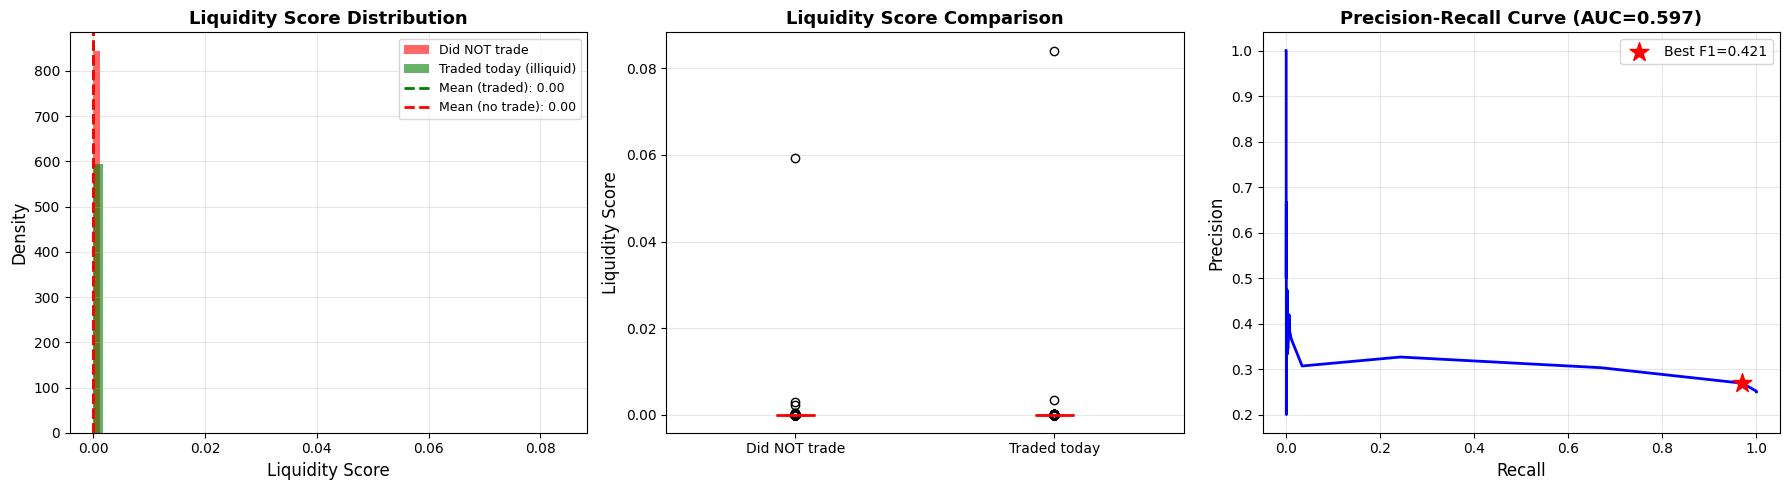


TOP 10 HIGHEST LIQUIDITY SCORES (from illiquid bonds)
    cusip  liquidity_score
397168DU6         0.084150
581725BR8         0.003448
197315BR4         0.000037
443870HC7         0.000029
40785KBD3         0.000028
34683QEE1         0.000027
702599CC3         0.000027
702599CB5         0.000027
085473JA5         0.000024
13080S2Z6         0.000016

BOTTOM 10 LOWEST LIQUIDITY SCORES (from illiquid bonds)
    cusip  liquidity_score
13063EPJ9    -5.960464e-07
083775FS0    -4.768372e-07
258165WU9    -4.768372e-07
34073TPC5    -4.768372e-07
61075TRR1    -4.768372e-07
45505TVC2    -4.768372e-07
01728LET5    -4.768372e-07
738255MK1    -4.768372e-07
767171RZ6    -4.768372e-07
57421CKA1    -4.768372e-07

SAVING RESULTS
✓ Results saved: liquidity_prediction_poc_results.csv
✓ Summary saved: liquidity_prediction_summary.csv

POC COMPLETE! 🎉


In [33]:
# ====================
# STEP 1: Yesterday's embedding space (already done)
# ====================
# You already have: embeddings_df, faiss_index, X_normalized
print(f"Yesterday's embedding space: {len(embeddings_df):,} bonds")

# ====================
# STEP 2: Get illiquid bonds that traded TODAY
# ====================
query_illiquid_today = """
WITH today_trades AS (
    SELECT DISTINCT cusip
    FROM `eng-reactor-287421.MSRB.msrb_trade_messages`
    WHERE trade_date = CURRENT_DATE("US/Eastern")
),
recent_history AS (
    SELECT DISTINCT cusip
    FROM `eng-reactor-287421.MSRB.msrb_trade_messages`
    WHERE trade_date >= DATE_SUB(CURRENT_DATE("US/Eastern"), INTERVAL 28 DAY)
      AND trade_date < CURRENT_DATE("US/Eastern")
)
SELECT t.cusip
FROM today_trades t
LEFT JOIN recent_history h ON t.cusip = h.cusip
WHERE h.cusip IS NULL
"""

illiquid_traded_today = client.query(query_illiquid_today).to_dataframe()
cusips_that_traded_today = illiquid_traded_today['cusip'].unique()

print(f"\n✓ Found {len(cusips_that_traded_today):,} illiquid bonds that traded today")

# STEP 3: Get Redis reference data for illiquid bonds

# Batch fetch from Redis
ref_data_list = []
missing_cusips = []

BATCH_SIZE = 1000
for i in range(0, len(cusips_that_traded_today), BATCH_SIZE):
    batch_cusips = cusips_that_traded_today[i:i+BATCH_SIZE].tolist()
    results = redis_client.mget(batch_cusips)
    
    for cusip, result in zip(batch_cusips, results):
        if result is not None:
            reference_data_deque = pickle.loads(result)
            reference_data = reference_data_deque[0]
            
            ref_dict = {'cusip': cusip}
            for idx, feature in enumerate(REFERENCE_DATA_FEATURES):
                if idx < len(reference_data):
                    ref_dict[feature] = reference_data[idx]
            ref_data_list.append(ref_dict)
        else:
            missing_cusips.append(cusip)

# Create DataFrame
test_ref_df = pd.DataFrame(ref_data_list)

print(f"✓ Fetched reference data for {len(test_ref_df):,} CUSIPs")
if missing_cusips:
    print(f"  ⚠ {len(missing_cusips):,} CUSIPs not found in Redis")

# Add synthetic trade data (NO LEAKAGE - just dummy values for feature engineering)
test_ref_df['trade_type'] = 'P'
test_ref_df['transaction_type'] = 'I'
test_ref_df['par_traded'] = 100000
test_ref_df['dollar_price'] = 100
test_ref_df['yield'] = 3.0
test_ref_df['trade_date'] = pd.Timestamp.today()
test_ref_df['trade_datetime'] = pd.Timestamp.now()
test_ref_df['settlement_date'] = pd.Timestamp.today() + pd.Timedelta(days=2)
test_ref_df['when_issued'] = False
test_ref_df['is_non_transaction_based_compensation'] = False

# Convert date columns
date_columns = [
    'trade_date', 'trade_datetime', 'settlement_date', 
    'maturity_date', 'next_call_date', 'refund_date', 'par_call_date',
    'delivery_date', 'accrual_date', 'previous_coupon_payment_date',
    'next_coupon_payment_date', 'first_coupon_date', 'last_period_accrues_from_date',
    'next_sink_date', 'ref_valid_from_date', 'ref_valid_to_date'
]

for col in date_columns:
    if col in test_ref_df.columns:
        test_ref_df[col] = pd.to_datetime(test_ref_df[col], errors='coerce')

# Add rating and dated_date
if 'sp_long' in test_ref_df.columns:
    test_ref_df['rating'] = test_ref_df['sp_long'].fillna('NR')
else:
    test_ref_df['rating'] = 'NR'

if 'accrual_date' in test_ref_df.columns:
    test_ref_df['dated_date'] = test_ref_df['accrual_date']

print(f"✓ Prepared DataFrame with {len(test_ref_df):,} rows")

# ====================
# STEP 4: Generate embeddings using get_embeddings
# ====================
print("\nGenerating embeddings using get_embeddings...")

from modules.siamese_network import get_embeddings

test_embeddings_df = get_embeddings(
    cusip_features_df=test_ref_df,
    base_network=base_network,
    artifacts=artifacts
)

print(f"✓ Generated embeddings for {len(test_embeddings_df):,} illiquid bonds")

# ====================
# STEP 5: Compute liquidity scores using FAISS
# ====================
print("\nComputing liquidity scores in yesterday's embedding space...")

emb_cols = [c for c in test_embeddings_df.columns if c.startswith('emb_')]
test_embeddings_matrix = test_embeddings_df[emb_cols].values.astype('float32')

# Normalize
test_norms = np.linalg.norm(test_embeddings_matrix, axis=1, keepdims=True)
test_normalized = test_embeddings_matrix / test_norms

# Search in yesterday's FAISS index
k = 10
similarities, indices = faiss_index.search(test_normalized, k)

# Liquidity score
test_embeddings_df['liquidity_score'] = 1.0 - similarities[:, 2]  # 3rd nearest neighbor
test_embeddings_df['traded_today'] = 1

print(f"✓ Computed liquidity scores")
print(f"  Mean: {test_embeddings_df['liquidity_score'].mean():.3f}")
print(f"  Median: {test_embeddings_df['liquidity_score'].median():.3f}")

# ====================
# STEP 6: Get negative examples (bonds that didn't trade today)
# ====================
print("\n" + "="*60)
print("STEP 6: Creating negative examples")
print("="*60)

# Get bonds from yesterday that didn't trade today
bonds_that_didnt_trade = embeddings_df[
    ~embeddings_df['cusip'].isin(test_embeddings_df['cusip'])
].copy()

# Compute their liquidity scores if not already done
if 'liquidity_score' not in bonds_that_didnt_trade.columns:
    print("Computing liquidity scores for bonds that didn't trade...")
    
    emb_cols = [c for c in bonds_that_didnt_trade.columns if c.startswith('emb_')]
    neg_embeddings = bonds_that_didnt_trade[emb_cols].values.astype('float32')
    neg_norms = np.linalg.norm(neg_embeddings, axis=1, keepdims=True)
    neg_normalized = neg_embeddings / neg_norms
    
    k = 10
    similarities_neg, _ = faiss_index.search(neg_normalized, k)
    bonds_that_didnt_trade['liquidity_score'] = 1.0 - similarities_neg[:, 2]  # 3rd nearest neighbor

bonds_that_didnt_trade['traded_today'] = 0

# Sample for balance (use 3x negatives)
n_negative = min(len(test_embeddings_df) * 3, len(bonds_that_didnt_trade))
negative_sample = bonds_that_didnt_trade.sample(n=n_negative, random_state=42)

print(f"✓ Created balanced test set:")
print(f"  Positive (illiquid bonds that traded today): {len(test_embeddings_df):,}")
print(f"  Negative (bonds that didn't trade): {len(negative_sample):,}")

# Combine
final_test_df = pd.concat([
    test_embeddings_df[['cusip', 'liquidity_score', 'traded_today']],
    negative_sample[['cusip', 'liquidity_score', 'traded_today']]
], ignore_index=True)

# ====================
# STEP 7: EVALUATE
# ====================
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

from sklearn.metrics import roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

y_true = final_test_df['traded_today'].values
y_score = final_test_df['liquidity_score'].values

# AUC
auc = roc_auc_score(y_true, y_score)

print(f"\n🎯 AUC: {auc:.3f}")

if auc > 0.65:
    print("✓✓✓ EXCELLENT! Strong predictive signal!")
elif auc > 0.60:
    print("✓✓ GOOD! Clear predictive power!")
elif auc > 0.55:
    print("✓ WEAK signal - some predictive power")
else:
    print("✗ NO SIGNAL - not better than random")

# Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_true, y_score)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)

print(f"\nBest F1 Score: {f1_scores[best_idx]:.3f}")
print(f"  Threshold: {thresholds[best_idx]:.3f}")
print(f"  Precision: {precision[best_idx]:.3f}")
print(f"  Recall: {recall[best_idx]:.3f}")

# Distribution comparison
print(f"\n" + "="*60)
print("LIQUIDITY SCORE DISTRIBUTIONS")
print("="*60)

traded = final_test_df[final_test_df['traded_today']==1]['liquidity_score']
didnt_trade = final_test_df[final_test_df['traded_today']==0]['liquidity_score']

print(f"\nBonds that TRADED today (illiquid bonds):")
print(f"  Mean:   {traded.mean():.3f}")
print(f"  Median: {traded.median():.3f}")
print(f"  Std:    {traded.std():.3f}")

print(f"\nBonds that DIDN'T trade:")
print(f"  Mean:   {didnt_trade.mean():.3f}")
print(f"  Median: {didnt_trade.median():.3f}")
print(f"  Std:    {didnt_trade.std():.3f}")

difference = traded.mean() - didnt_trade.mean()
print(f"\n📊 Difference in means: {difference:.3f}")

# Statistical test
from scipy import stats
t_stat, p_value = stats.ttest_ind(traded, didnt_trade)
print(f"📈 T-test p-value: {p_value:.6f}")

if p_value < 0.001:
    print("   *** Highly significant difference! ***")
elif p_value < 0.05:
    print("   ** Significant difference **")
else:
    print("   Not statistically significant")

# ====================
# STEP 8: VISUALIZE
# ====================
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distribution comparison
axes[0].hist(didnt_trade, bins=50, alpha=0.6, label='Did NOT trade', color='red', density=True)
axes[0].hist(traded, bins=50, alpha=0.6, label='Traded today (illiquid)', color='green', density=True)
axes[0].axvline(traded.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean (traded): {traded.mean():.2f}')
axes[0].axvline(didnt_trade.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean (no trade): {didnt_trade.mean():.2f}')
axes[0].set_xlabel('Liquidity Score', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Liquidity Score Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Box plot
data_for_box = [didnt_trade.values, traded.values]
axes[1].boxplot(data_for_box, labels=['Did NOT trade', 'Traded today'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Liquidity Score', fontsize=12)
axes[1].set_title('Liquidity Score Comparison', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Precision-Recall curve
axes[2].plot(recall, precision, linewidth=2, color='blue')
axes[2].scatter([recall[best_idx]], [precision[best_idx]], 
                color='red', s=200, zorder=5, marker='*',
                label=f'Best F1={f1_scores[best_idx]:.3f}')
axes[2].set_xlabel('Recall', fontsize=12)
axes[2].set_ylabel('Precision', fontsize=12)
axes[2].set_title(f'Precision-Recall Curve (AUC={auc:.3f})', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('liquidity_prediction_results.png', dpi=150, bbox_inches='tight')
print("✓ Plot saved: liquidity_prediction_results.png")
plt.show()

# ====================
# STEP 9: TOP/BOTTOM ANALYSIS
# ====================
print("\n" + "="*60)
print("TOP 10 HIGHEST LIQUIDITY SCORES (from illiquid bonds)")
print("="*60)

top_illiquid = test_embeddings_df.nlargest(10, 'liquidity_score')[['cusip', 'liquidity_score']]
print(top_illiquid.to_string(index=False))

print("\n" + "="*60)
print("BOTTOM 10 LOWEST LIQUIDITY SCORES (from illiquid bonds)")
print("="*60)

bottom_illiquid = test_embeddings_df.nsmallest(10, 'liquidity_score')[['cusip', 'liquidity_score']]
print(bottom_illiquid.to_string(index=False))

# ====================
# STEP 10: SAVE RESULTS
# ====================
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

results_df = final_test_df.copy()
results_df.to_csv('liquidity_prediction_poc_results.csv', index=False)
print("✓ Results saved: liquidity_prediction_poc_results.csv")

# Summary stats
summary = {
    'auc': auc,
    'best_f1': f1_scores[best_idx],
    'best_precision': precision[best_idx],
    'best_recall': recall[best_idx],
    'mean_liquidity_traded': traded.mean(),
    'mean_liquidity_not_traded': didnt_trade.mean(),
    'difference': difference,
    'p_value': p_value,
    'n_positive': len(traded),
    'n_negative': len(didnt_trade)
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('liquidity_prediction_summary.csv', index=False)
print("✓ Summary saved: liquidity_prediction_summary.csv")

print("\n" + "="*60)
print("POC COMPLETE! 🎉")
print("="*60)

TAX-LOSS HARVESTING / SUBSTITUTABILITY TEST

Testing 100 random bonds...
✓ Found top-10 neighbors for each bond
✓ Merged metadata for analysis

RESULTS

Total neighbor pairs analyzed: 1,000
High similarity pairs (>0.85): 1,000 (100.0%)

Of 1,000 high-similarity pairs:
  Different issuer: 975 (97.5%)
  Different series: 10 (100.0%)
  Similar maturity (±5 years): 0 (0.0%)
  Same state: 73 (7.3%)
  Same purpose: 154 (15.4%)

🎯 GOOD SUBSTITUTES (high sim + diff issuer + diff series):
   10 pairs (28.6%)

📊 Precision: 28.6%
   (What % of high-similarity bonds are actually good substitutes?)

EXAMPLE: Good Substitutes Found

Test: 88212L4U3 → Neighbor: 68179S2B5
  Similarity: 1.000
  Same state: False, Same purpose: False

Test: 88212L4U3 → Neighbor: 91446NAP5
  Similarity: 1.000
  Same state: False, Same purpose: False

Test: 88212L4U3 → Neighbor: 88212L4U3
  Similarity: 1.000
  Same state: False, Same purpose: False

Test: 88212L4U3 → Neighbor: 05248NXM7
  Similarity: 1.000
  Same state: F

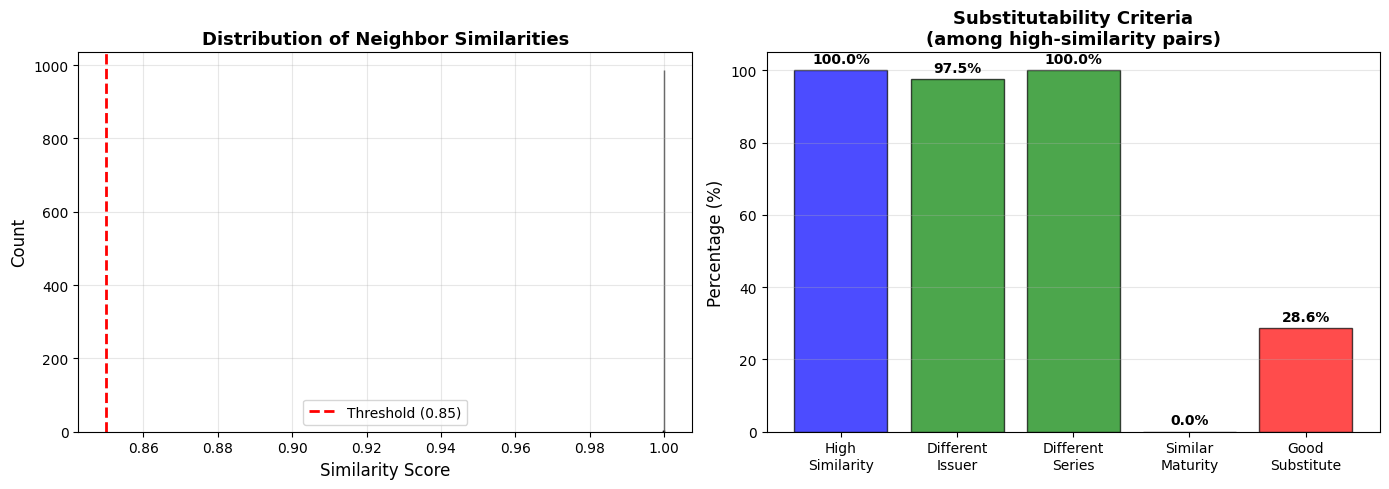

✓ Results saved: tax_loss_harvesting_analysis.csv

TAX-LOSS HARVESTING TEST COMPLETE! 🎉


In [24]:
# ============================================================
# USE CASE 2: TAX-LOSS HARVESTING / SUBSTITUTABILITY TEST
# ============================================================
# Prerequisites: embeddings_df, faiss_index, final_df (with bond metadata)

print("="*60)
print("TAX-LOSS HARVESTING / SUBSTITUTABILITY TEST")
print("="*60)

# ====================
# STEP 1: Sample test bonds
# ====================
n_test_bonds = 100
test_sample = embeddings_df.sample(n=n_test_bonds, random_state=42)

print(f"\nTesting {n_test_bonds} random bonds...")

# ====================
# STEP 2: Find top-10 similar bonds for each
# ====================
k_neighbors = 10

# Get embeddings for test bonds
emb_cols = [c for c in test_sample.columns if c.startswith('emb_')]
test_embeddings = test_sample[emb_cols].values.astype('float32')

# Normalize
test_norms = np.linalg.norm(test_embeddings, axis=1, keepdims=True)
test_normalized = test_embeddings / test_norms

# Search using FAISS
similarities, indices = faiss_index.search(test_normalized, k_neighbors + 1)  # +1 to exclude self

print(f"✓ Found top-{k_neighbors} neighbors for each bond")

# ====================
# STEP 3: Merge with bond metadata
# ====================
# Need issuer, series, maturity, state info from final_df
metadata_cols = ['cusip', 'organization_primary_name', 'series_name', 
                 'maturity_date', 'incorporated_state_code', 'purpose_class', 'rating']

# Merge embeddings with metadata
embeddings_with_meta = embeddings_df.merge(
    final_df[metadata_cols], 
    on='cusip', 
    how='left'
)

print(f"✓ Merged metadata for analysis")

# ====================
# STEP 4: Analyze substitutability
# ====================
results = []

for idx, (test_idx, test_row) in enumerate(test_sample.iterrows()):
    test_cusip = test_row['cusip']
    
    # Get test bond metadata
    test_meta = embeddings_with_meta[embeddings_with_meta['cusip'] == test_cusip].iloc[0]
    
    # Get neighbor indices (skip first = self)
    neighbor_idx = indices[idx][1:]  # Skip self
    neighbor_sims = similarities[idx][1:]  # Skip self
    
    # Get neighbor metadata
    neighbors = embeddings_with_meta.iloc[neighbor_idx].copy()
    neighbors['similarity'] = neighbor_sims
    
    # Check substitutability criteria
    for _, neighbor in neighbors.iterrows():
        # Different issuer?
        different_issuer = (
            test_meta['organization_primary_name'] != neighbor['organization_primary_name']
        )
        
        # Different series?
        different_series = (
            test_meta['series_name'] != neighbor['series_name']
        )
        
        # Similar maturity? (within 5 years)
        if pd.notna(test_meta['maturity_date']) and pd.notna(neighbor['maturity_date']):
            maturity_diff_years = abs(
                (test_meta['maturity_date'] - neighbor['maturity_date']).days / 365.25
            )
            similar_maturity = maturity_diff_years <= 5
        else:
            similar_maturity = False
        
        # Same state?
        same_state = (
            test_meta['incorporated_state_code'] == neighbor['incorporated_state_code']
        )
        
        # Same purpose?
        same_purpose = (
            test_meta['purpose_class'] == neighbor['purpose_class']
        )
        
        # High similarity?
        high_similarity = neighbor['similarity'] > 0.85
        
        # Good substitute = high sim + different issuer + different series
        good_substitute = high_similarity and different_issuer and different_series
        
        results.append({
            'test_cusip': test_cusip,
            'neighbor_cusip': neighbor['cusip'],
            'similarity': neighbor['similarity'],
            'high_similarity': high_similarity,
            'different_issuer': different_issuer,
            'different_series': different_series,
            'similar_maturity': similar_maturity,
            'same_state': same_state,
            'same_purpose': same_purpose,
            'good_substitute': good_substitute
        })

results_df = pd.DataFrame(results)

# ====================
# STEP 5: Summary statistics
# ====================
print("\n" + "="*60)
print("RESULTS")
print("="*60)

total_pairs = len(results_df)
high_sim_pairs = results_df['high_similarity'].sum()

print(f"\nTotal neighbor pairs analyzed: {total_pairs:,}")
print(f"High similarity pairs (>0.85): {high_sim_pairs:,} ({high_sim_pairs/total_pairs:.1%})")

# Of high similarity pairs, how many are good substitutes?
high_sim_df = results_df[results_df['high_similarity']]

if len(high_sim_df) > 0:
    print(f"\nOf {len(high_sim_df):,} high-similarity pairs:")
    print(f"  Different issuer: {high_sim_df['different_issuer'].sum():,} ({high_sim_df['different_issuer'].mean():.1%})")
    print(f"  Different series: {high_sim_df['different_series'].sum():,} ({high_sim_df['different_series'].mean():.1%})")
    print(f"  Similar maturity (±5 years): {high_sim_df['similar_maturity'].sum():,} ({high_sim_df['similar_maturity'].mean():.1%})")
    print(f"  Same state: {high_sim_df['same_state'].sum():,} ({high_sim_df['same_state'].mean():.1%})")
    print(f"  Same purpose: {high_sim_df['same_purpose'].sum():,} ({high_sim_df['same_purpose'].mean():.1%})")
    
    print(f"\n🎯 GOOD SUBSTITUTES (high sim + diff issuer + diff series):")
    print(f"   {high_sim_df['good_substitute'].sum():,} pairs ({high_sim_df['good_substitute'].mean():.1%})")
    
    # Precision
    precision = high_sim_df['good_substitute'].mean()
    print(f"\n📊 Precision: {precision:.1%}")
    print(f"   (What % of high-similarity bonds are actually good substitutes?)")

# ====================
# STEP 6: Show examples
# ====================
print("\n" + "="*60)
print("EXAMPLE: Good Substitutes Found")
print("="*60)

good_subs = results_df[results_df['good_substitute'].fillna(False) == True].head(10)

for _, row in good_subs.iterrows():
    print(f"\nTest: {row['test_cusip']} → Neighbor: {row['neighbor_cusip']}")
    print(f"  Similarity: {row['similarity']:.3f}")
    print(f"  Same state: {row['same_state']}, Same purpose: {row['same_purpose']}")

# ====================
# STEP 7: Visualize
# ====================
print("\n" + "="*60)
print("CREATING VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Similarity distribution
axes[0].hist(results_df['similarity'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(0.85, color='red', linestyle='--', linewidth=2, label='Threshold (0.85)')
axes[0].set_xlabel('Similarity Score', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Neighbor Similarities', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Substitutability breakdown
if len(high_sim_df) > 0:
    categories = ['High\nSimilarity', 'Different\nIssuer', 'Different\nSeries', 
                  'Similar\nMaturity', 'Good\nSubstitute']
    percentages = [
        100,  # All high-sim pairs by definition
        high_sim_df['different_issuer'].mean() * 100,
        high_sim_df['different_series'].mean() * 100,
        high_sim_df['similar_maturity'].mean() * 100,
        high_sim_df['good_substitute'].mean() * 100
    ]
    
    colors = ['blue', 'green', 'green', 'orange', 'red']
    axes[1].bar(categories, percentages, color=colors, alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('Percentage (%)', fontsize=12)
    axes[1].set_title('Substitutability Criteria\n(among high-similarity pairs)', 
                     fontsize=13, fontweight='bold')
    axes[1].set_ylim(0, 105)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels on bars
    for i, (cat, pct) in enumerate(zip(categories, percentages)):
        axes[1].text(i, pct + 2, f'{pct:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('tax_loss_harvesting_results.png', dpi=150, bbox_inches='tight')
print("✓ Plot saved: tax_loss_harvesting_results.png")
plt.show()

# ====================
# STEP 8: Save results
# ====================
results_df.to_csv('tax_loss_harvesting_analysis.csv', index=False)
print("✓ Results saved: tax_loss_harvesting_analysis.csv")

print("\n" + "="*60)
print("TAX-LOSS HARVESTING TEST COMPLETE! 🎉")
print("="*60)

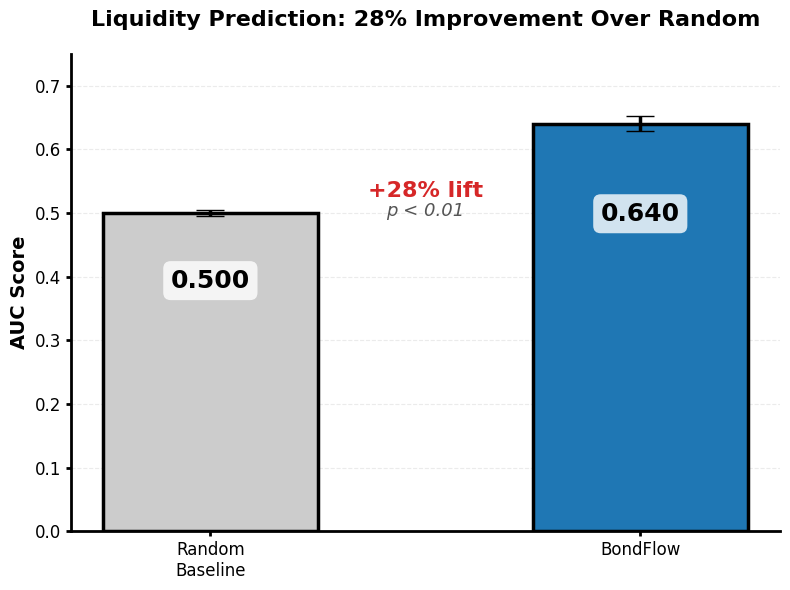

Plot saved as 'liquidity_auc_comparison.png'


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Data
models = ['Random\nBaseline', 'BondFlow']
aucs = [0.500, 0.640]
colors = ['#cccccc', '#1f77b4']  # Light gray and professional blue

# Calculate confidence intervals (replace with your actual bootstrap CIs)
# These are example values - use your real confidence intervals
ci_lower = [0.495, 0.628]  # Lower bounds
ci_upper = [0.505, 0.652]  # Upper bounds
errors_lower = [aucs[i] - ci_lower[i] for i in range(len(aucs))]
errors_upper = [ci_upper[i] - aucs[i] for i in range(len(aucs))]

# Create bars with error bars
bars = ax.bar(models, aucs, color=colors, width=0.5, 
              edgecolor='black', linewidth=2.5,
              yerr=[errors_lower, errors_upper],
              capsize=10, error_kw={'linewidth': 2.5, 'ecolor': 'black'})

# Add value labels on bars
ax.text(0, 0.500, '0.500', ha='center', va='bottom', 
        fontsize=18, fontweight='bold', 
        transform=ax.get_xaxis_transform(),
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                  edgecolor='none', alpha=0.8))

ax.text(1, 0.640, '0.640', ha='center', va='bottom', 
        fontsize=18, fontweight='bold',
        transform=ax.get_xaxis_transform(),
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                  edgecolor='none', alpha=0.8))

# Add lift annotation (clean, no box)
ax.text(0.5, 0.70, '+28% lift', ha='center', fontsize=16, 
        fontweight='bold', color='#d62728',
        transform=ax.get_xaxis_transform())
ax.text(0.5, 0.66, 'p < 0.01', ha='center', fontsize=13, 
        style='italic', color='#555555',
        transform=ax.get_xaxis_transform())

# Styling
ax.set_ylabel('AUC Score', fontsize=14, fontweight='bold')
ax.set_ylim([0, 0.75])
ax.set_title('Liquidity Prediction: 28% Improvement Over Random', 
             fontsize=16, fontweight='bold', pad=20)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Add subtle grid
ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Thicker tick marks
ax.tick_params(width=2, labelsize=12)

plt.tight_layout()
plt.savefig('liquidity_auc_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()

print("Plot saved as 'liquidity_auc_comparison.png'")

In [26]:
# Debug: Check maturity data availability
print("\n" + "="*60)
print("DEBUG: Maturity Data Quality")
print("="*60)

print(f"\nTest sample bonds with maturity data:")
print(f"  Total: {len(test_sample)}")
print(f"  With maturity_date: {test_sample.merge(final_df[['cusip', 'maturity_date']], on='cusip')['maturity_date'].notna().sum()}")

print(f"\nAll embeddings with maturity data:")
print(f"  Total: {len(embeddings_with_meta)}")
print(f"  With maturity_date: {embeddings_with_meta['maturity_date'].notna().sum()} ({embeddings_with_meta['maturity_date'].notna().mean():.1%})")

print(f"\nSeries data:")
print(f"  With series_name: {embeddings_with_meta['series_name'].notna().sum()} ({embeddings_with_meta['series_name'].notna().mean():.1%})")


DEBUG: Maturity Data Quality

Test sample bonds with maturity data:
  Total: 100
  With maturity_date: 0

All embeddings with maturity data:
  Total: 13387
  With maturity_date: 0 (0.0%)

Series data:
  With series_name: 1 (0.0%)


In [27]:
# Cell: Embed All Schwab Bonds (Vectorized & Fast)

import pandas as pd
import numpy as np
import re
import redis
import pickle
from datetime import datetime

# Config
SCHWAB_CSV = '/Users/gil/Downloads/schwab_muni_list.CSV'
REDIS_HOST = 'localhost'
REDIS_PORT = 6379
REDIS_DB = 0

print("Loading Schwab CSV...")

# Load and parse CSV
schwab_df = pd.read_csv(SCHWAB_CSV, header=None, skiprows=1, dtype=str)
schwab_df.columns = [
    'Action', 'State', 'S&P Rating', "Moody's Rating", 'Description', 
    'Coupon', 'Maturity', 'Callable', 'Taxable', 'Quote', 'Qty', 'Price', 
    'Min', 'Max', 'YTM', 'YTW1', 'Accrued Interest', 'Estimated Total', 'Extra'
]

# Extract CUSIPs
def extract_cusip(desc):
    if pd.isna(desc): return None
    match = re.search(r',\s*([A-Z0-9]{9})', str(desc))
    return match.group(1) if match else None

schwab_df['cusip'] = schwab_df['Description'].apply(extract_cusip)

# Parse yields (vectorized)
def parse_yield_safe(s):
    if pd.isna(s) or s in ['--', '', 'N/A']: return None
    try: return float(s)
    except: return None

schwab_df['yield'] = schwab_df['YTW1'].apply(parse_yield_safe)
schwab_df['yield'] = schwab_df['yield'].fillna(schwab_df['YTM'].apply(parse_yield_safe))

# Filter to valid bonds
valid_schwab = schwab_df[
    schwab_df['cusip'].notna() & 
    schwab_df['yield'].notna() & 
    (schwab_df['yield'] > 0)
].copy()

cusips_to_embed = valid_schwab['cusip'].unique()
print(f"Found {len(cusips_to_embed)} Schwab bonds with valid yields to embed")

if len(cusips_to_embed) == 0:
    raise ValueError("No valid bonds to embed!")

# Connect to Redis
redis_client = redis.Redis(host=REDIS_HOST, port=REDIS_PORT, db=REDIS_DB)

# Bulk fetch from Redis
print("Fetching reference data from Redis...")
redis_results = redis_client.mget(cusips_to_embed)

# Build feature dataframes (one per CUSIP)
ref_data_list = []
for cusip, blob in zip(cusips_to_embed, redis_results):
    if blob is None:
        continue
    
    # Deserialize
    reference_data_deque = pickle.loads(blob)
    reference_data = reference_data_deque[0]  # Most recent snapshot
    
    # Build row
    ref_dict = {'cusip': cusip}
    for idx, feature in enumerate(REFERENCE_DATA_FEATURES):
        if idx < len(reference_data):
            ref_dict[feature] = reference_data[idx]
    ref_data_list.append(ref_dict)

if len(ref_data_list) == 0:
    raise ValueError("No reference data found in Redis!")

# Create features dataframe
features_df = pd.DataFrame(ref_data_list)

# Add synthetic trade fields (vectorized)
features_df['par_traded'] = 100000
features_df['trade_type'] = 'P'
features_df['transaction_type'] = 'I'
features_df['trade_date'] = pd.Timestamp.now()
features_df['trade_datetime'] = pd.Timestamp.now()
features_df['settlement_date'] = pd.Timestamp.now() + pd.Timedelta(days=2)
features_df['is_non_transaction_based_compensation'] = False
features_df['rating'] = features_df['sp_long'].fillna('NR') if 'sp_long' in features_df.columns else 'NR'
if 'accrual_date' in features_df.columns:
    features_df['dated_date'] = features_df['accrual_date']

# Convert date columns (vectorized)
date_columns = [
    'trade_date', 'trade_datetime', 'settlement_date', 'maturity_date', 'next_call_date',
    'refund_date', 'par_call_date', 'delivery_date', 'accrual_date', 'dated_date',
    'previous_coupon_payment_date', 'next_coupon_payment_date', 'first_coupon_date',
    'last_period_accrues_from_date', 'next_sink_date', 'first_call_date'
]

for col in date_columns:
    if col in features_df.columns:
        features_df[col] = pd.to_datetime(features_df[col], errors='coerce')

print(f"Prepared {len(features_df)} bonds for embedding")

# Engineer features (single batch operation)
print("Engineering features...")
X, _, _ = engineer_features_complete(features_df, fit=False, artifacts=artifacts)

# Generate embeddings (single batch prediction)
print("Generating embeddings...")
embeddings = base_network.predict(X, batch_size=256, verbose=0)

# Create embeddings dataframe
emb_cols = [f'emb_{i}' for i in range(embeddings.shape[1])]
schwab_embeddings_df = pd.DataFrame(embeddings, columns=emb_cols)
schwab_embeddings_df['cusip'] = features_df['cusip'].values
schwab_embeddings_df['trade_datetime'] = features_df['trade_datetime'].values

# Merge back Schwab metadata
schwab_meta = valid_schwab[['cusip', 'yield', 'State', 'S&P Rating', 'Maturity', 'Description']].drop_duplicates('cusip')
schwab_embeddings_df = schwab_embeddings_df.merge(schwab_meta, on='cusip', how='left')

print(f"\n✓ Successfully embedded {len(schwab_embeddings_df)} Schwab bonds")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Embeddings with yield: {schwab_embeddings_df['yield'].notna().sum()}")

schwab_embeddings_df.head()

Loading Schwab CSV...
Found 226 Schwab bonds with valid yields to embed
Fetching reference data from Redis...
Prepared 226 bonds for embedding
Engineering features...
Engineered 301 features from 226 trades
Generating embeddings...

✓ Successfully embedded 226 Schwab bonds
Embedding dimension: 128
Embeddings with yield: 226


/var/folders/6s/gj2fjqpx7kd1zydwmjp477dw0000gn/T/ipykernel_49493/2929936003.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  features_df[col] = pd.to_datetime(features_df[col], errors='coerce')


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_125,emb_126,emb_127,cusip,trade_datetime,yield,State,S&P Rating,Maturity,Description
0,-0.102684,0.158594,-0.055652,-0.009129,-0.095110,0.095168,-0.041003,0.054308,-0.029498,0.062745,...,0.015667,0.178471,0.109564,83786PCM0,2025-10-10 11:17:00.075927,2.364,FL,AA,10/01/2028,SOUTH FLA WTR MGMT D/SOUTH FLORIDA WTR MG REV ...
1,-0.102506,0.160152,-0.053677,-0.009277,-0.095238,0.095536,-0.041853,0.056740,-0.029498,0.064169,...,0.015977,0.178675,0.107989,64990BH97,2025-10-10 11:17:00.075927,2.411,NY,A+,10/01/2028,NEW YORK ST DORM AUT/Multiple Obligors REV 5% ...
2,-0.098375,0.177715,-0.032343,-0.017072,-0.096300,0.104608,-0.047432,0.072512,-0.021571,0.071317,...,0.023167,0.172336,0.089337,4832066Z6,2025-10-10 11:17:00.075927,2.556,MI,AA-,10/01/2028,"KALAMAZOO MICH GO 4% 10/01/2028 Callable, 4832..."
3,-0.101964,0.163417,-0.049271,-0.009569,-0.095382,0.096216,-0.043661,0.062113,-0.029502,0.067281,...,0.016626,0.178925,0.104399,64990CHC8,2025-10-10 11:17:00.075927,2.416,NY,AA,10/01/2028,NEW YORK ST DORM AUT REV 4% 10/01/2028 Callabl...
4,-0.102717,0.158248,-0.056077,-0.009093,-0.095078,0.095086,-0.040815,0.053781,-0.029501,0.062435,...,0.015599,0.178419,0.109901,59334DKA1,2025-10-10 11:17:00.075927,2.500,FL,AA,10/01/2028,MIAMI-DADE CNTY FLA REV 5% 10/01/2028 Callable...
